In [ ]:
import numpy as np
import cv2
import os
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt

def imshow(title = "Image", image = None, size=10):
  w,h = image.shape[0], image.shape[1]
  aspect_ratio = w/h
  plt.figure(figsize=(size*aspect_ratio,size))
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.title(title)
  plt.show()

!gdown --id 1QWPRnL02rOgm6xZmcmfyWVuVubKeYry4
!unzip -q colorize.zip

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1QWPRnL02rOgm6xZmcmfyWVuVubKeYry4
To: /content/colorize.zip
100% 120M/120M [00:00<00:00, 206MB/s]


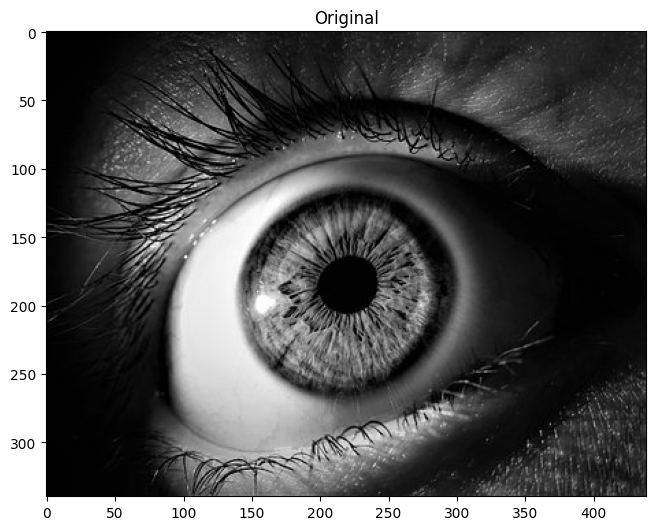

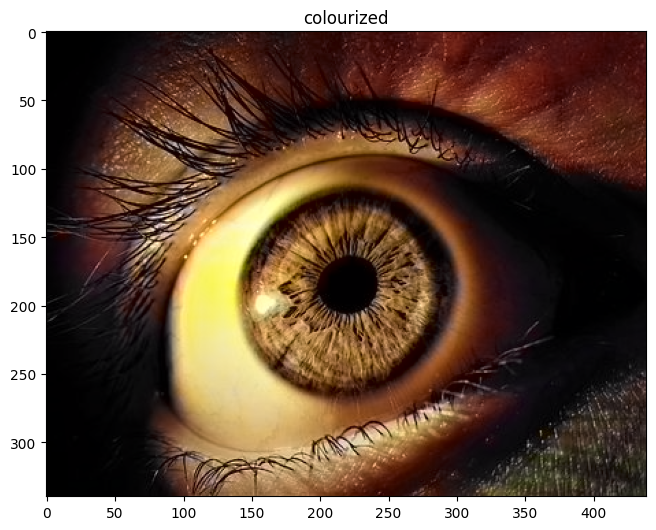

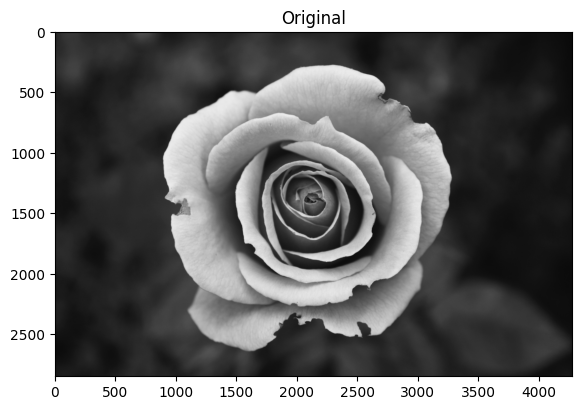

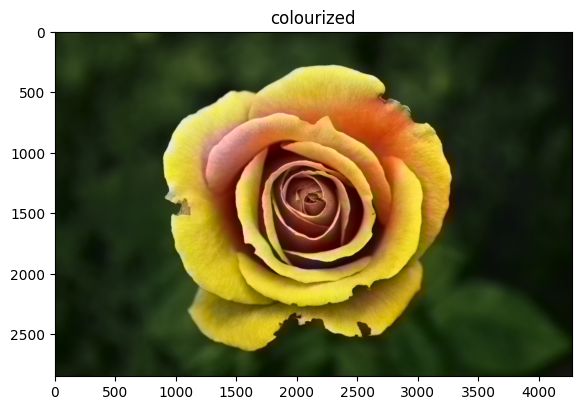

In [ ]:
file_path = "/content/colorize/blackandwhite/"

blackandwhite_imgs = [f for f in listdir(file_path) if isfile(join(file_path, f))]
kernel = 'colorize/pts_in_hull.npy'

if __name__ == '__main__':
  net = cv2.dnn.readNetFromCaffe("/content/colorize/colorization_deploy_v2.prototxt",
                                 "/content/colorize/colorization_release_v2.caffemodel")
  pts_in_hull = np.load(kernel)
  pts_in_hull = pts_in_hull.transpose().reshape(2, 313, 1, 1)
  net.getLayer(net.getLayerId('class8_ab')).blobs = [pts_in_hull.astype(np.float32)]
  net.getLayer(net.getLayerId('conv8_313_rh')).blobs = [np.full([1, 313], 2.606, np.float32)]

  for image in blackandwhite_imgs:
    img = cv2.imread(file_path+image)

    img_rgb = (img[:,:,[2,1,0]] * 1.0/255).astype(np.float32)
    img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2LAB)

    img_l = img_lab[:,:,0]

    (H_orig,W_orig) = img_rgb.shape[:2]

    img_rs = cv2.resize(img_rgb, (224, 224))

    img_lab_rs = cv2.cvtColor(img_rs, cv2.COLOR_RGB2Lab)
    img_l_rs = img_lab_rs[:,:,0]

    img_l_rs -= 50
    net.setInput(cv2.dnn.blobFromImage(img_l_rs))

    ab_dec = net.forward('class8_ab')[0,:,:,:].transpose((1, 2, 0))

    (H_out, W_out) = ab_dec.shape[:2]
    ab_dec_us = cv2.resize(ab_dec, (W_orig, H_orig))
    img_lab_out = np.concatenate((img_l[:,:,np.newaxis], ab_dec_us), axis = 2)

    img_bgr_out = np.clip(cv2.cvtColor(img_lab_out, cv2.COLOR_Lab2BGR), 0, 1)

    imshow('Original', img)
    img_bgr_out = cv2.resize(img_bgr_out, (W_orig, H_orig), interpolation = cv2.INTER_AREA)
    imshow("colourized", img_bgr_out)